#### vae https://github.com/AntixK/PyTorch-VAE/blob/8700d245a9735640dda458db4cf40708caf2e77f/models/vanilla_vae.py

In [1]:
from torch import nn
from abc import abstractmethod
from typing import List, Callable, Union, Any, TypeVar, Tuple
import sys
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

import torch
from torch import nn
from torch.nn import functional as F

dict_vae = {
    "0":[256, 256, 256, 256, 512, 512], #vae0
    "1":[256, 256, 256, 256, 512, 512, 1024], #vae1
    "2":[256, 256, 256, 256, 512, 512, 1024, 1024], #vae2
    "3":[256, 256, 256, 256, 512, 512, 1024], #vae3
    "10":[256, 256, 512, 512, 512, 1024, 1024], # vae10 新的开始
    "11":[512, 512, 512, 512, 512, 512, 1024], # vae11 新的开始
    "12":[512, 512, 512, 512, 512, 512, 1024], # vae12 新的开始 batch_size为512
    "13":[512, 512, 512, 512, 512, 512, 1024], # vae13 新的开始 batch_size为1024
    "14":[512, 512, 512, 512, 512, 512, 1024], # vae14 新的开始 batch_size为2048
    "15":[512, 512, 512, 512, 512, 512, 1024], # vae15 新的开始 batch_size为2048, 将kl散度较14缩小10倍，即kl_alf= batch_size / 50000 / 10
    "16":[512, 512, 512, 512, 512, 512, 1024], # vae16 新的开始 batch_size为2048, 将kl散度较14缩小20倍，即kl_alf= batch_size / 50000 / 10 / 2
    "17":[1024, 1024, 1024, 1024, 1024, 1024, 1024], # 从17开始，epoch都是200，vae17 batch_size为2048, kl_alf= batch_size / 50000 / 10 / 2
    "18":[1024, 1024, 1024, 1024, 1024, 1024, 2048], # vae18 batch_size为2048, kl_alf= batch_size / 50000 / 10 / 2
    "19":[2048, 2048, 2048, 2048, 2048, 2048, 2048], # vae19 batch_size为2048, kl_alf= batch_size / 50000 if条件那里没改过来所以，kl权重没有除以20
    "20":[2048, 2048, 1024, 1024, 1024, 2048, 2048], # vae20 batch_size为2048, kl_alf= batch_size / 50000 / 10 / 2
    "21":[1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 2048], # vae21 batch_size为2048, kl_alf= batch_size / 50000 / 10 / 2
    "22":[1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 2048], # vae22，这个batch_size再调小一点kl_alf= batch_size / 50000 / 40
    "23":[1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 2048], # vae23，这个batch_size再调小一点kl_alf= batch_size / 50000 / 80
    "24":[1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 2048], # vae24，这个batch_size再调小一点kl_alf= batch_size / 50000 / 160
    "25":[1024, 1024, 1024, 1024, 1024, 1024, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 2048], # vae25，这个batch_size再调小一点kl_alf= batch_size / 50000 / 1600
}

class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_features: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 hidden_id: str = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        if hidden_dims is None:
            hidden_dims = dict_vae[hidden_id]



        # Build Encoder
        modules = []
        
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=h_dim),
                    nn.LeakyReLU())
            )
            in_features = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

        hidden_dims.reverse() #数组反转
        in_features = hidden_dims[0]
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=h_dim),
                    nn.LeakyReLU())
            )
            in_features = h_dim
            

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=208),
            nn.Tanh())
        

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N']
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return [loss, recons_loss, -kld_loss]

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

#### vae_BN

In [2]:

import torch
from torch import nn
from torch.nn import functional as F

dict_vae = {
    "0":[256, 128, 64, 32],
    "1":[256, 256, 128, 64, 32],
    "2":[256, 256, 256, 256],
    "3":[256, 256, 256, 256, 512, 512],
    "4":[512, 512, 512, 512, 512, 512, 1024],
    "5":[1024, 1024, 1024, 1024, 1024, 1024, 2048],
    "6":[2048, 2048, 1024, 1024, 1024, 2048, 2048],
    "01":[256, 128, 64, 32], # 这里的kl系数在100epoch之前是逐渐增大的
    "02":[256, 128, 64, 32], # 增大batch_size为
}

class VanillaVAE_BN(BaseVAE):


    def __init__(self,
                 in_features: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 hidden_id: str = None,
                 **kwargs) -> None:
        super(VanillaVAE_BN, self).__init__()

        self.latent_dim = latent_dim

        if hidden_dims is None:
            hidden_dims = dict_vae[hidden_id]



        # Build Encoder
        modules = []
        
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=h_dim),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_features = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

        hidden_dims.reverse() #数组反转
        in_features = hidden_dims[0]
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=h_dim),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_features = h_dim
            

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=208),
            nn.Tanh())
        

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N']
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return [loss, recons_loss, -kld_loss]

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

#### 数据处理

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

from torch.nn import functional as F
from tqdm import tqdm
# 定义数据集类
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)



#### 模型训练

In [4]:
num_epochs = 3000
batch_size = 128
learning_rate = 5e-4
device = torch.device('cuda:1')
kl_alf=0.01
import model_files as model_all


id_number = "02"
vae = VanillaVAE_BN(in_features=208, latent_dim=2, hidden_id=id_number).to(device)
vae_dict = torch.load("./临时垃圾-随时可删/vae_BN测试/vae" + id_number + ".pt", map_location=device) # 当时我保存模型的时候save的是vae.state_dict没有加上括号
vae.load_state_dict(vae_dict)
vae.eval()
# vae.load_state_dict(torch.load("./model_files/CIFAR10/checkpoints/vae/vae2.pt", map_location=device))
# vae.eval()

# vae = VanillaVAE(in_features=208, latent_dim=2).to(device)
# vae.load_state_dict(torch.load("./model_files/CIFAR10/checkpoints/vae/vae.pt", map_location=device))
# vae.train()
# optimizer = torch.optim.Adam(vae.parameters(), lr=0.005)

VanillaVAE_BN(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=208, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)


In [5]:
import model_files as model_all #模型的连接在__init__.py中体现
import random

BigGAN = model_all.get_generative_model("CIFAR10")
# 选择生成模型
checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=162000.pth"
G = BigGAN.to(device)
G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
G.eval()
number = 50000

save_pic_path = "./static/data/CIFAR10/pic/random_"+ str(number//1000) +"k"



for num in tqdm(range(number)):
    z = torch.tensor(np.random.RandomState(num).randn(1, 80)).to(torch.float32).to(device)    # latent code
    label = torch.tensor(random.randrange(10)).unsqueeze(0).to(device)
    shared_label = G.shared(label)
    z_and_shared_label = torch.cat((z, shared_label), dim = 1)
    if num == 0:
        zs_all = z_and_shared_label
    else:
        zs_all = torch.cat((zs_all, z_and_shared_label))
print(zs_all.shape)

100%|██████████| 50000/50000 [00:18<00:00, 2688.23it/s]

torch.Size([50000, 208])


In [6]:
dataset = MyDataset(zs_all)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:

for i, latent_208 in enumerate(dataloader):
    mu, log_var = vae.encode(latent_208)
    z2 = vae.reparameterize(mu, log_var)
    if i == 0:
        z2_all = z2
    else:
        z2_all = torch.cat((z2_all, z2))
print(z2_all.shape)

torch.Size([50000, 2])


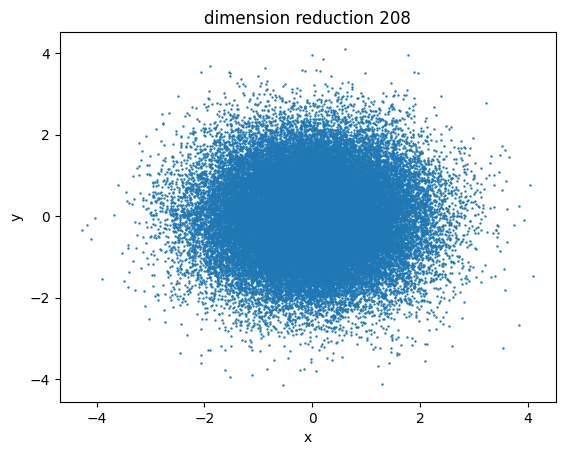

In [8]:
import matplotlib.pyplot as plt
data2d = z2_all.cpu().detach().numpy()
plt.scatter(data2d[:, 0], data2d[:, 1], s=0.5)
# 添加坐标轴标签和图标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('dimension reduction 208')
plt.show()

#### 随机采样打样，忽略

In [9]:
# sample_z = torch.randn(50000, 2)
# data2d = sample_z.cpu().detach().numpy()
# plt.scatter(data2d[:, 0], data2d[:, 1], s=0.5)
# # 添加坐标轴标签和图标题
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('random sample 208')
# plt.show()

In [10]:
# # 计算坐标点的协方差矩阵
# cov = np.cov(data2d.T)

# # 生成符合多元正态分布的新坐标点
# new_coords = np.random.multivariate_normal(np.mean(data2d, axis=0), cov, size=50000)
# plt.scatter(new_coords[:, 0], new_coords[:, 1], s=0.5)
# # 添加坐标轴标签和图标题
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Scatter Plot of Normalized Data')
# plt.show()

#### vae采样生成

In [11]:
import matplotlib.pyplot as plt
# 生成新数据

zs = vae.sample(50000, device)

In [12]:
latent_z_path="./static/data/CIFAR10/latent_z/BigGAN_208z_50000.pt"
latent_z = torch.load(latent_z_path, map_location=device) #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
print(latent_z[0])

tensor([ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676, -0.9773,  0.9501, -0.1514,
        -0.1032,  0.4106,  0.1440,  1.4543,  0.7610,  0.1217,  0.4439,  0.3337,
         1.4941, -0.2052,  0.3131, -0.8541, -2.5530,  0.6536,  0.8644, -0.7422,
         2.2698, -1.4544,  0.0458, -0.1872,  1.5328,  1.4694,  0.1549,  0.3782,
        -0.8878, -1.9808, -0.3479,  0.1563,  1.2303,  1.2024, -0.3873, -0.3023,
        -1.0486, -1.4200, -1.7063,  1.9508, -0.5097, -0.4381, -1.2528,  0.7775,
        -1.6139, -0.2127, -0.8955,  0.3869, -0.5108, -1.1806, -0.0282,  0.4283,
         0.0665,  0.3025, -0.6343, -0.3627, -0.6725, -0.3596, -0.8131, -1.7263,
         0.1774, -0.4018, -1.6302,  0.4628, -0.9073,  0.0519,  0.7291,  0.1290,
         1.1394, -1.2348,  0.4023, -0.6848, -0.8708, -0.5788, -0.3116,  0.0562,
        -0.2827,  0.4797,  0.2446, -0.2046,  2.1742,  0.5331, -0.1289,  0.1671,
         0.6368, -1.8712,  0.5975, -0.1503,  0.6386,  0.0323, -0.9272, -0.1543,
        -0.9216, -0.9502,  1.5223, -0.18

In [13]:

mu, log_var = vae.encode(latent_z[0].unsqueeze(0))
print(mu, log_var)
z = vae.reparameterize(mu, log_var)
print(z)

tensor([[-0.0268,  0.0043]], device='cuda:1', grad_fn=<AddmmBackward>) tensor([[ 0.0324, -0.0022]], device='cuda:1', grad_fn=<AddmmBackward>)
tensor([[-0.2266,  1.2685]], device='cuda:1', grad_fn=<AddBackward0>)


In [14]:
recon_latent = vae.decode(z)
print(recon_latent)

tensor([[ 5.3544e-03, -1.1059e-04, -2.0712e-04,  3.9353e-03, -2.6855e-02,
          2.8773e-02,  2.4224e-02, -7.4253e-03,  6.4010e-03,  3.0491e-03,
          2.2894e-02,  3.8896e-03,  1.8979e-02, -2.8179e-02, -7.1309e-03,
          1.4862e-02,  2.2837e-02, -2.4330e-02, -5.1731e-03,  1.7382e-03,
          1.4134e-02, -4.7312e-02, -2.5235e-02,  5.8729e-03, -9.0111e-03,
         -9.1196e-03,  5.6692e-03,  1.8636e-02, -1.3028e-02,  8.2750e-03,
          1.1331e-02,  1.5696e-03, -5.6867e-03,  7.4658e-03, -1.1954e-04,
         -8.4442e-03,  9.5032e-03,  1.0085e-02,  3.9656e-02, -1.2113e-02,
         -1.0181e-02, -1.1081e-02, -4.9136e-03, -4.6471e-03, -1.3712e-02,
          3.3240e-02, -2.8737e-02, -4.3304e-02, -2.4744e-02, -4.5193e-03,
          1.7331e-02, -3.4662e-03, -4.0432e-02, -5.0744e-03,  1.8649e-03,
          9.4211e-03,  1.9236e-02,  2.4153e-03, -2.1709e-02, -7.3284e-03,
          2.2214e-03,  3.1764e-02,  2.8347e-03, -2.0977e-02, -4.4183e-02,
          2.2800e-02, -3.1737e-02,  2.

In [15]:
print(zs.shape)

torch.Size([50000, 208])


In [16]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# 用来处理zs的类，方便使用batchsize
class Mydata_sets(Dataset):
    
    def __init__(self, zs):
        super(Mydata_sets, self).__init__()
        self.zs = zs

    def __getitem__(self, index):
        z = self.zs[index]
        return z

    def __len__(self):
        return len(self.zs)

zs = zs.cpu()
zs_datasets = Mydata_sets(zs)
zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)
model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as model_all
checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=162000.pth"

G = model_all.get_generative_model("CIFAR10").to(device)
G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
G.eval()
print()

In [17]:
import torchvision.transforms as transforms
import torchvision.utils as utils


first = 0 # 判断是否第一次进入循环
count = 0
with torch.no_grad(): # 取消梯度计算，加快运行速度
    for batch_z in zs_loader: 
        z = torch.tensor(batch_z).to(torch.float32).to(device)    # latent code
        imgs = G(z)   
        for i, img in enumerate(imgs):
            img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
            utils.save_image(img.detach().cpu(), f'./临时垃圾-随时可删/sample2D_50k/pic{count}.jpg')
            count += 1

/home/kuangjielong/.conda/envs/python3_7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":


In [18]:
import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import fid_score as official_fid
# fid计算模型
dims = 2048
batch_size = 1
num_avail_cpus = len(os.sched_getaffinity(0))
num_workers = min(num_avail_cpus, 8)
block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
fid_model = official_fid.InceptionV3([block_idx]).to(device)
print('fid_model load success!')


pic_path_fid1 = './临时垃圾-随时可删/sample2D_50k/'
pic_path_fid2 = './static/data/CIFAR10/pic/random_50k'
    
batch_size = 100
m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                    dims, device, num_workers)
m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                    dims, device, num_workers)
fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
print(fid_value)

fid_model load success!


100%|██████████| 500/500 [00:50<00:00,  9.85it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
400.4474549492192


In [19]:
print(fid_value)

400.4474549492192
